In [1]:
import sys
sys.path.append('../src')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm

import dataloader

%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

model_name = 'vit'
data_dir = '/home/jstock/data/conus3/A/'
ymax = 60

In [2]:
def get_data(filename):
    loss, met = [], [] # assumes (train, val) dims
    with open(filename) as fi:
        for ln in fi:
            if ln.startswith('train loss'):
                ln = ln.rstrip()
                loss.append(re.findall(r'loss: (\d+\.\d+)', ln))
                met.append(re.findall(r'met: (\d+\.\d+)', ln))

    loss = np.stack(loss).astype(float)
    met = np.stack(met).astype(float)
    return loss, met

In [3]:
log = 'log_3807'
loss, met = get_data(f'../logs/{log}.out')

/tmp/tmp.SgAt4bC03h/ipykernel_300161/128484635.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral', 8)


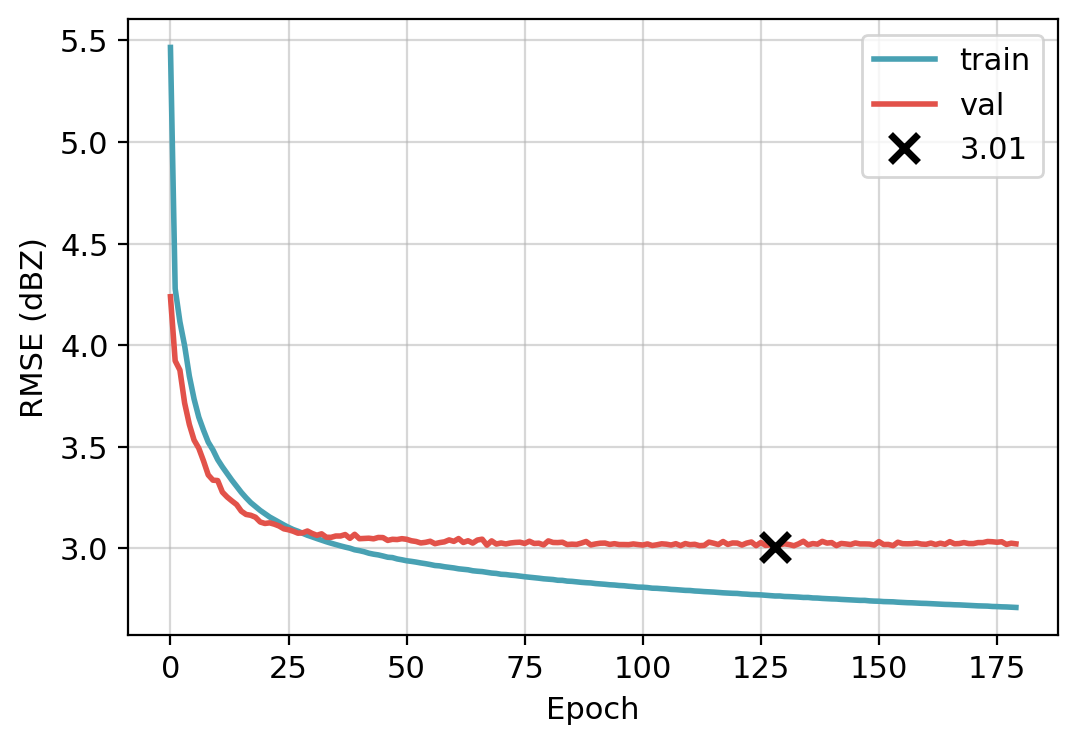

In [27]:
cmap = cm.get_cmap('Spectral', 8)

fontsize = 11
lw = 2
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(met[:,0] * ymax, label='train', ls='-', lw=lw,
        color=cmap(6))
ax.plot(met[:,1] * ymax, label='val', ls='-', lw=lw, 
        color=cmap(1))
min_x = np.argmin(met[:,1])
min_y = met[min_x,1] * ymax
ax.plot(min_x, min_y, 'x', color='black', ms=10, mew=2.5, label=f'{min_y:.2f}')
ax.set_xlabel('Epoch', fontsize=fontsize)
ax.set_ylabel('RMSE (dBZ)', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid(alpha=0.5)
fig.savefig(os.path.join('../media', f'loss.png'), dpi=300, bbox_inches='tight')

In [5]:
xt_samples = []
v = os.path.join(data_dir, 'test')
for f in os.listdir(v):
    if f.endswith('.npz'):
        xt_samples.append(os.path.join(v, f))
xt_samples.sort()

y_samples = []
v = os.path.join(data_dir, 'out', model_name)
for f in os.listdir(v):
    if f.endswith('.npy'):
        y_samples.append(os.path.join(v, f))
y_samples.sort()

In [7]:
rmse = lambda t, y: np.sqrt(np.mean((y - t)**2))
mse = lambda t, y: np.mean((y - t)**2)

def load_xty(xt, y, idx):
    with np.load(xt[idx]) as data:  # C x H x W
        x = np.flip(np.moveaxis(data['xdata'], -1, 0), axis=1)
        t = np.flip(data['ydata'][np.newaxis, ...], axis=1) * ymax

    y = np.flip(np.load(y[idx]), axis=1) * ymax
    
    return x, t, y

(4, 768, 1536) (1, 768, 1536) (1, 768, 1536)
rmse: 3.51978, rmse: 12.38884


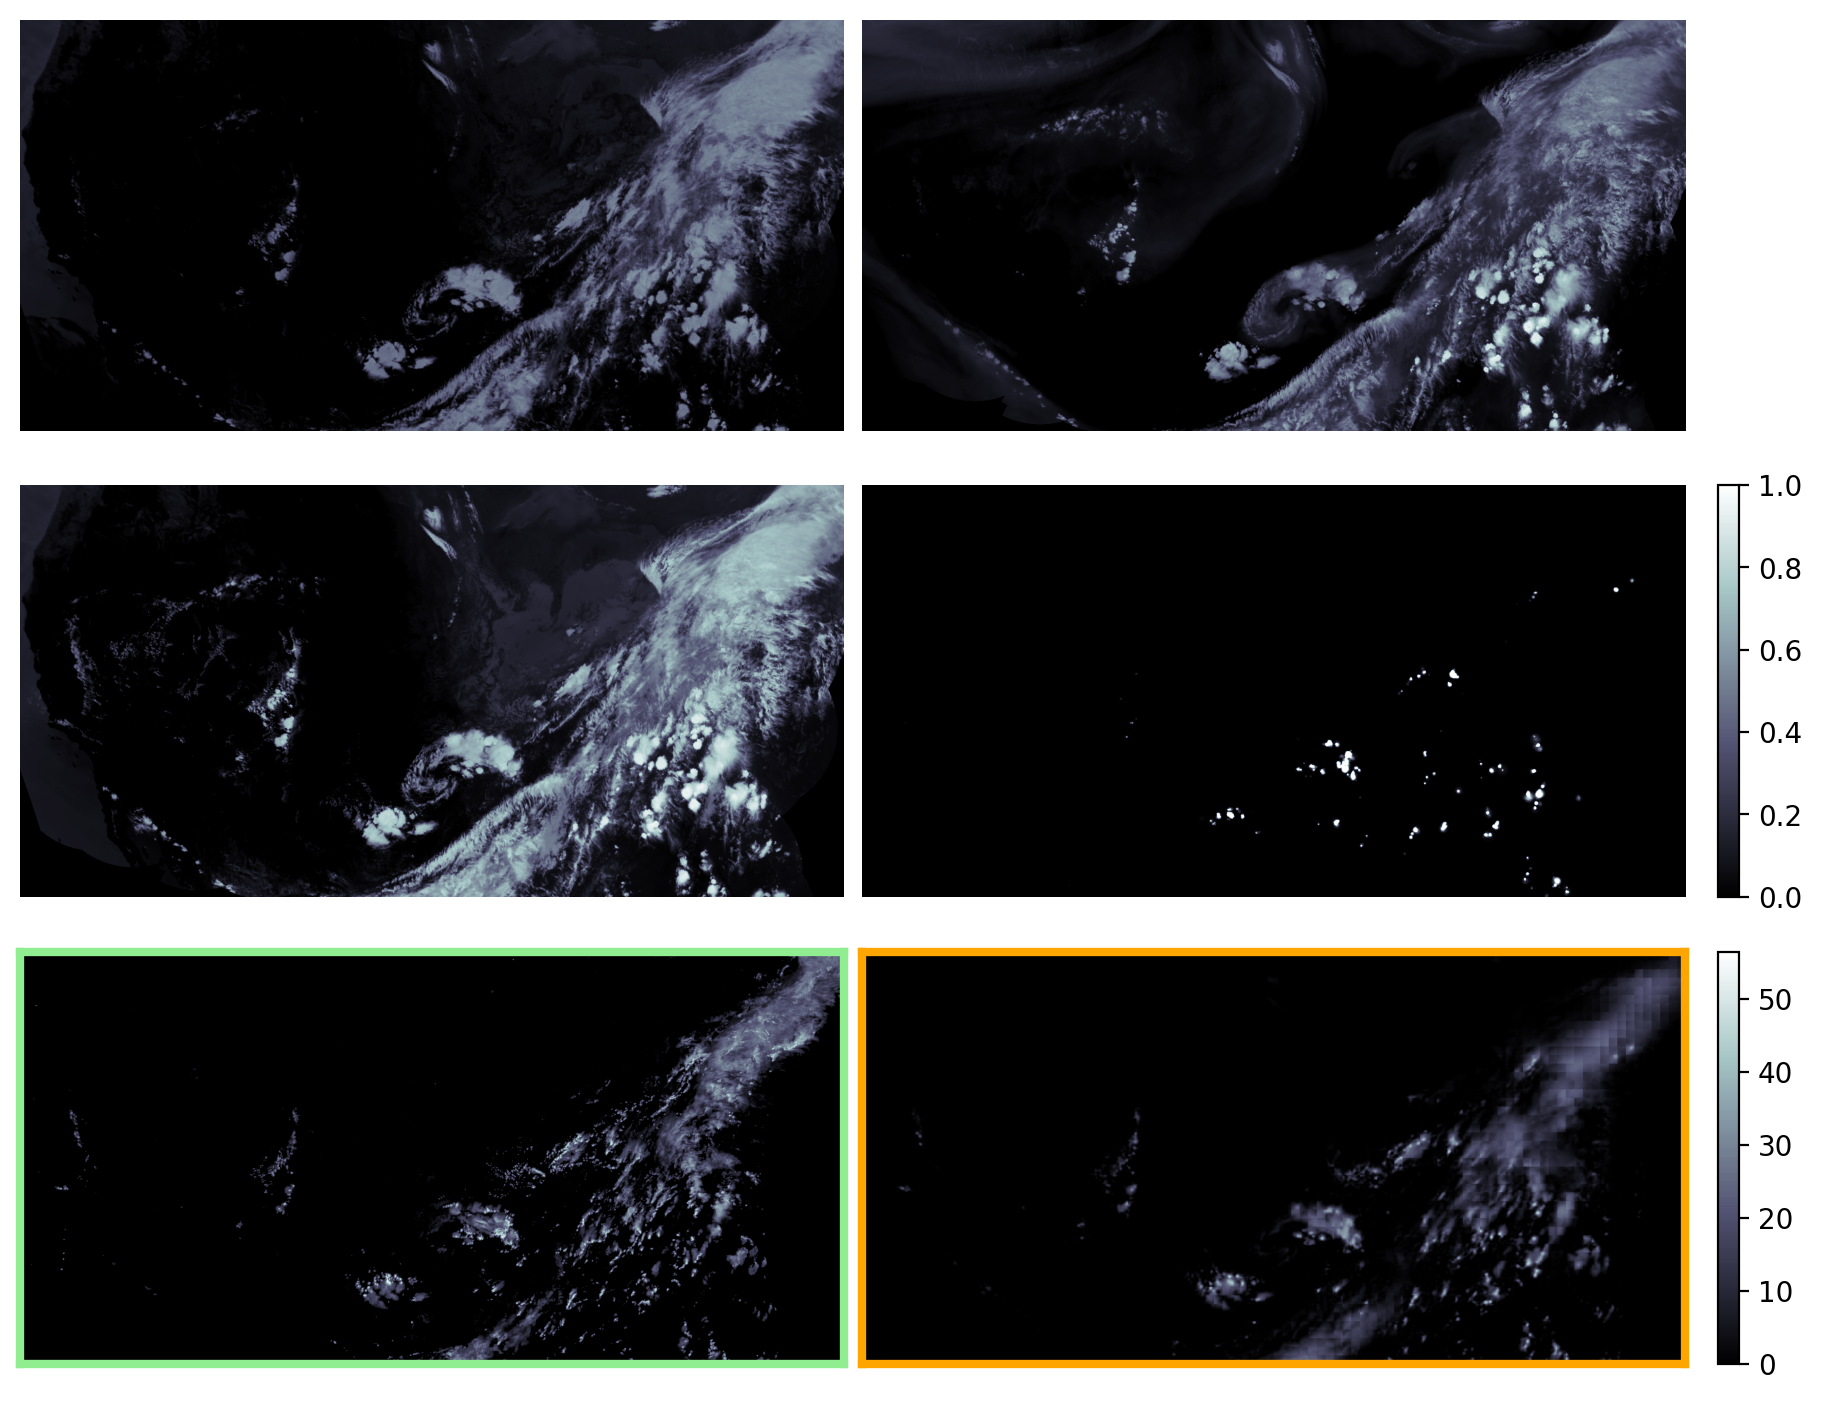

In [20]:
index = 15000
x, t, y = load_xty(xt_samples, y_samples, index)
print(x.shape, t.shape, y.shape)

fig, axs = plt.subplots(3, 2, figsize=(9,7), constrained_layout=True)
axs = axs.ravel()
for i in range(x.shape[0]):
    imx = axs[i].imshow(x[i], cmap='bone', vmin=x.min(), vmax=x.max())
    axs[i].axis('off')
fig.colorbar(imx, ax=axs[3], fraction=0.025, pad=0.04)

axs[-2].imshow(t[0], cmap='bone', vmin=t.min(), vmax=t.max())
imt = axs[-1].imshow(y[0], cmap='bone', vmin=t.min(), vmax=t.max())
fig.colorbar(imt, ax=axs[-1], fraction=0.025, pad=0.04)

for spine in axs[-2].spines.values():
    spine.set_edgecolor('lightgreen')
    spine.set_linewidth(3)

for spine in axs[-1].spines.values():
    spine.set_edgecolor('orange')
    spine.set_linewidth(3)

for ax in axs:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

fig.savefig(f'../media/test_{index}.png', dpi=300, bbox_inches='tight')

print(f'rmse: {rmse(y, t):.5f}, rmse: {mse(y, t):.5f}')

In [25]:
dataset = 'val'
distribution_sample_map = np.flip(np.load(os.path.join(data_dir, 'out', f'distribution_sample_map_{dataset}.npy')), axis=0)
output_sample_counts = np.load(os.path.join(data_dir, 'out', f'output_sample_counts_{dataset}.npy')) / np.prod((1, 768, 1536))

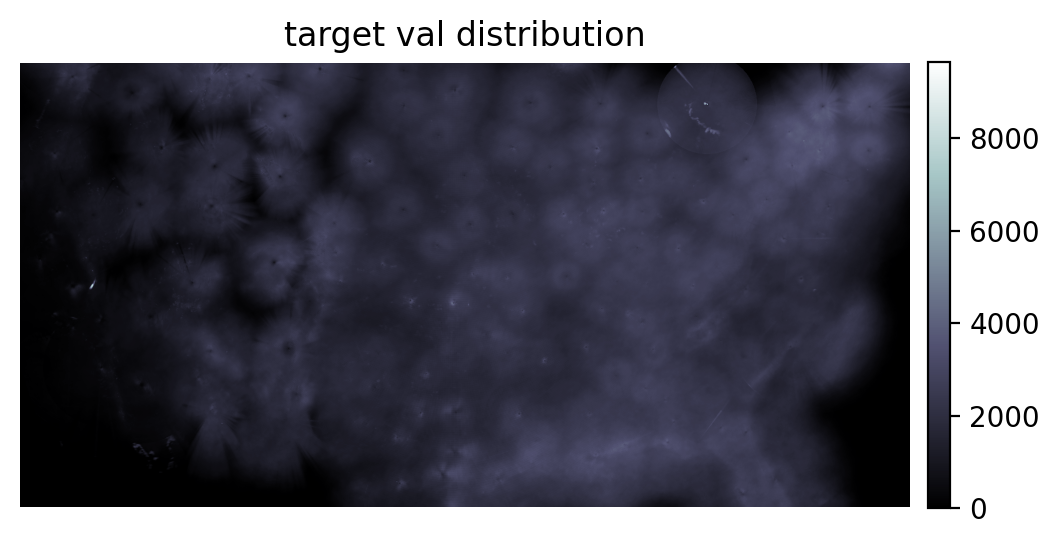

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
im = ax.imshow(distribution_sample_map, cmap='bone')
ax.axis('off')
fig.colorbar(im, ax=ax, fraction=0.024, pad=0.02)
ax.set_title(f'target {dataset} distribution')
fig.savefig(f'../media/distribution_map_{dataset}.png', dpi=300, bbox_inches='tight')

plt.show()

In [174]:

from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

/tmp/tmp.GjmQKtVPmy/ipykernel_1842057/4017853771.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral', 8)


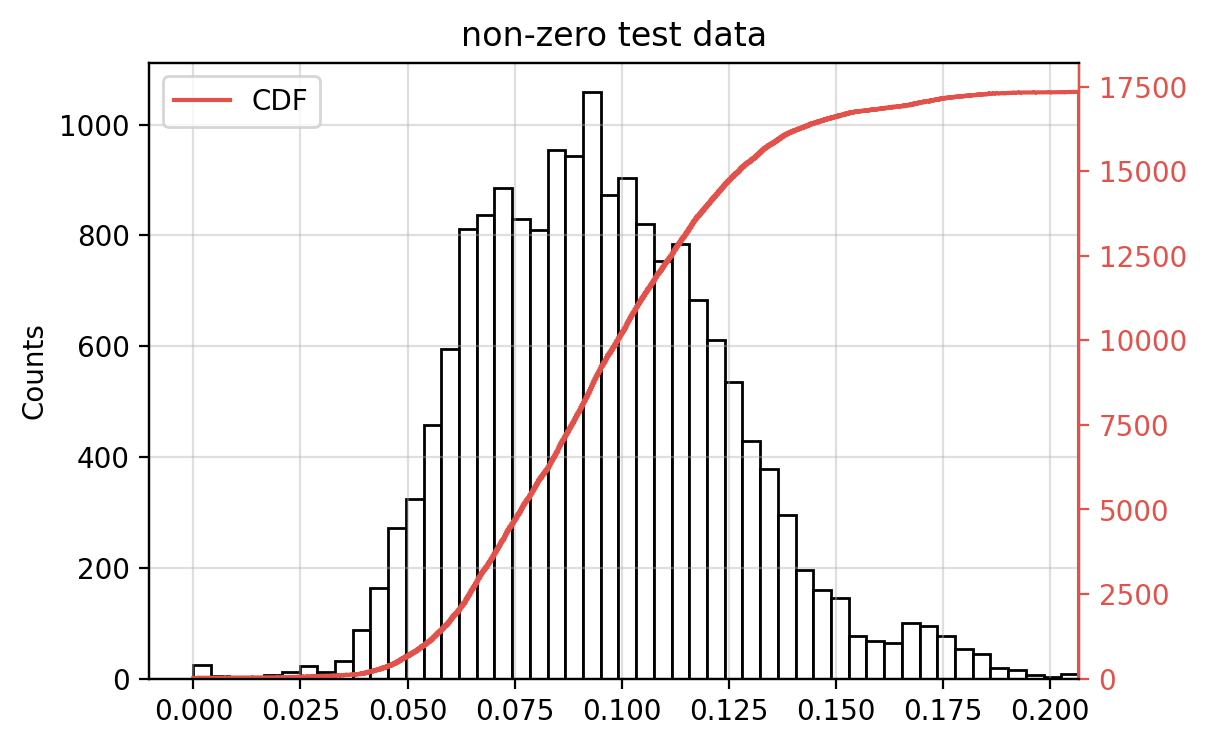

In [175]:
cmap = cm.get_cmap('Spectral', 8)
fontsize = 11
lw = 1.5

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist(output_sample_counts, bins=50, density=False,
        facecolor='w', edgecolor='k')
ax.set_title(f'non-zero {dataset} data')
ax.set_ylabel(f'Counts')

ax2 = ax.twinx()
color_idx = 1
ax2.hist(output_sample_counts, cumulative=1, lw=lw,
         histtype='step', bins=1000, color=cmap(color_idx))
ax.set_xlim((ax.get_xlim()[0], output_sample_counts.max()))
ax2.tick_params(axis='y', colors=cmap(color_idx))
ax2.spines['right'].set_color(cmap(color_idx))

custom_legend = [Line2D([0],[0], color=cmap(color_idx), lw=lw)]
ax2.legend(custom_legend, ['CDF'])

# kds = gaussian_kde(output_sample_counts)
# xs = np.linspace(output_sample_counts.min(), 
#                  output_sample_counts.max(), 1000)
# ax.plot(xs, kds(xs), '-k')

ax.grid(alpha=0.4)
fig.savefig(f'../media/distribution_{dataset}.png', dpi=300, bbox_inches='tight')
plt.show()